<a href="https://colab.research.google.com/github/nimamt/machine_learning/blob/master/pytorch/reinforcement/DistributionalDQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rainbow DQN

This is actually the implementation of **Rainbow DQN** because it is a combination of different methods (also available in Github) rather than a simple implementation of "*A Distributional Perspective on Reinforcement Learning*" (**C51 Algorithm**).

In [ ]:
!apt-get install -y xvfb

!pip install \
  gym[atari,accept-rom-license]==0.23.1 \
  pytorch-lightning==1.6.0 \
  stable-baselines3 \
  pyvirtualdisplay

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 21 not upgraded.
Need to get 780 kB of archives.
After this operation, 2,271 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 xvfb amd64 2:1.20.13-1ubuntu1~20.04.6 [780 kB]
Fetched 780 kB in 2s (376 kB/s)
Selecting previously unselected package xvfb.
(Reading database ... 128126 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.20.13-1ubuntu1~20.04.6_amd64.deb ...
Unpacking xvfb (2:1.20.13-1ubuntu1~20.04.6) ...
Setting up xvfb (2:1.20.13-1ubuntu1~20.04.6) ...
Processing triggers for man-db (2.9.1-1) ...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev

In [ ]:
from pyvirtualdisplay import Display
Display(visible=False, size=(1400, 900)).start()

In [ ]:
import copy
import torch
import random
import gym
import matplotlib

import numpy as np
import matplotlib.pyplot as plt

import torch.nn.functional as F

from collections import deque, namedtuple
from IPython.display import HTML
from base64 import b64encode

from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import IterableDataset
from torch.optim import AdamW

from pytorch_lightning import LightningModule, Trainer

from gym.wrappers import TransformObservation, NormalizeObservation, \
  NormalizeReward, RecordVideo, RecordEpisodeStatistics, AtariPreprocessing


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
num_gpus = torch.cuda.device_count()

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
def display_video(episode=0):
  video_file = open(f'/content/videos/rl-video-episode-{episode}.mp4', "r+b").read()
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"")

In [ ]:
import math
from torch.nn.init import kaiming_uniform_, zeros_

class NoisyLinear(nn.Module):

  def __init__(self, in_features, out_features, sigma):
    super(NoisyLinear, self).__init__()

    self.w_mu = nn.Parameter(torch.empty((out_features, in_features)))
    self.w_sigma = nn.Parameter(torch.empty((out_features, in_features)))
    self.b_mu = nn.Parameter(torch.empty((out_features)))
    self.b_sigma = nn.Parameter(torch.empty((out_features)))

    kaiming_uniform_(self.w_mu, a=math.sqrt(5))    
    kaiming_uniform_(self.w_sigma, a=math.sqrt(5)) 
    zeros_(self.b_mu)
    zeros_(self.b_sigma)

  def forward(self, x, sigma=0.5):
    # Bigger sigma - More spread around - More noise
    
    if self.training:
      w_noise = torch.normal(0, sigma, size=self.w_mu.size()).to(device)
      b_noise = torch.normal(0, sigma, size=self.b_mu.size()).to(device)
      return F.linear(x, self.w_mu + self.w_sigma * w_noise, 
                    self.b_mu + self.b_sigma * b_noise)
    else:
      return F.linear(x, self.w_mu, self.b_mu)

In [ ]:
class DQN(nn.Module):

  def __init__(self, hidden_size, obs_shape, n_actions, sigma=0.5, atoms=51):
    super().__init__()
    self.atoms = atoms
    self.n_actions = n_actions

    self.conv = nn.Sequential(
        nn.Conv2d(obs_shape[0], 64, kernel_size=3),
        nn.MaxPool2d(kernel_size=4),
        nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=3),
        nn.MaxPool2d(kernel_size=4),
        nn.ReLU(),
    )

    conv_out_size = self._get_conv_out(obs_shape)
    self.head = nn.Sequential(
        NoisyLinear(conv_out_size, hidden_size, sigma=sigma),
        nn.ReLU(),
    )

    # Q(s, a) = V(s) + Adv(s, a)
    self.fc_value = NoisyLinear(hidden_size, atoms, sigma=sigma)
    self.fc_adv = NoisyLinear(hidden_size, n_actions * atoms, sigma=sigma)

  def _get_conv_out(self, shape):
    conv_out = self.conv(torch.zeros(1, *shape))
    return int(np.prod(conv_out.size()))

  def forward(self, x):
    x = self.conv(x.float()).view(x.size()[0], -1) # First arg is batch_size
    x = self.head(x)
    # (B, A * N) -> (B, A, N)
    adv = self.fc_adv(x).view(-1, self.n_actions, self.atoms)
    # Target: (B, 1, N)
    value = self.fc_value(x).view(-1, 1, self.atoms)
    # (B, A, N)
    q_logits = value + adv - torch.mean(adv, dim=1, keepdim=True)
    q_probs = F.softmax(q_logits, dim=-1)
    return q_probs

In [ ]:
class ReplayBuffer: 

  def __init__(self, capacity):
    super().__init__()
    self.buffer = deque(maxlen=capacity) # Will automatically delete old entries
    # to make room for new ones

    # stores priorites of each of the samples contained in the buffer
    self.priorities = deque(maxlen=capacity)

    self.capacity = capacity

    self.alpha = 1.0
    self.beta = 0.5
    self.max_priority = 0.0

  def __len__(self):
    return len(self.buffer)

  def append(self, experience):
    self.buffer.append(experience)
    self.priorities.append(self.max_priority)

  def update(self, index, priority):
    if priority > self.max_priority:
      self.max_priority = priority
    self.priorities[index] = priority 
  def sample(self, batch_size):
    probs = np.array(self.priorities, dtype=np.float64) + 1e-4
    probs = probs ** self.alpha
    probs = probs / probs.sum()

    weights = (self.__len__() * probs) ** -self.beta
    weights = weights / weights.max()

    idx = random.choices(range(self.__len__()), weights=probs, k=batch_size)
    sample = [(i, weights[i], *self.buffer[i]) for i in idx]    
    return sample

In [ ]:
class RLDataset(IterableDataset):

  def __init__(self, buffer, sample_size=200):
    self.buffer = buffer
    self.sample_size = sample_size

  def __iter__(self):
    for experience in self.buffer.sample(self.sample_size):
      yield experience

In [ ]:
def greedy(state, net, support):
  state = torch.tensor([state]).to(device)
  q_value_probs = net(state) # (1, A, N)
  q_values = (support * q_value_probs).sum(dim=-1) # (1, A)
  action = torch.argmax(q_values, dim=-1) # (1, 1)
  action = int(action.item())
  return action

In [ ]:
env = gym.make('QbertNoFrameskip-v4')

In [ ]:
env.observation_space, env.action_space

(Box(0, 255, (210, 160, 3), uint8), Discrete(6))

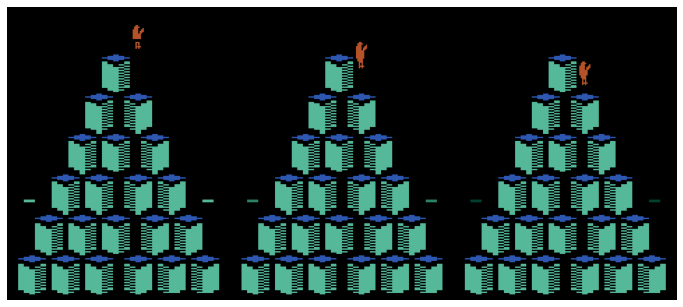

In [ ]:
frames = []
i = 200
skip = 4
obs = env.reset()
done = False

while not done:
  frames.append(obs)
  obs, _, done, _ = env.step(env.action_space.sample())

img = np.hstack([frames[i], frames[i+skip], frames[i+2*skip]])
plt.figure(figsize=(12, 8))
plt.axis("off")
plt.imshow(img)

In [ ]:
def create_environment(name):
  env = gym.make(name)
  env = RecordVideo(env, 'videos', episode_trigger=lambda e: e % 100 == 0)
  env = RecordEpisodeStatistics(env)
  env = AtariPreprocessing(env, frame_skip=8, screen_size=42)
  env = TransformObservation(env, lambda x: x[np.newaxis, :, :])
  env.observation_space = gym.spaces.Box(low=0, high=255, shape=(1, 42, 42), dtype=np.float32)
  env = NormalizeObservation(env)
  env = NormalizeReward(env)
  return env

In [ ]:
# env = create_environment('QbertNoFrameskip-v4')

# for episode in range(10):
#   done = False
#   obs = env.reset()
#   while not done:
#     obs, _, done, _ = env.step(env.action_space.sample())

In [ ]:
# display_video(episode=0)

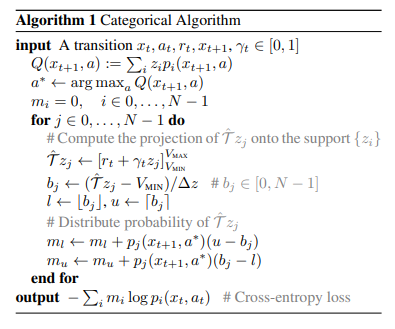

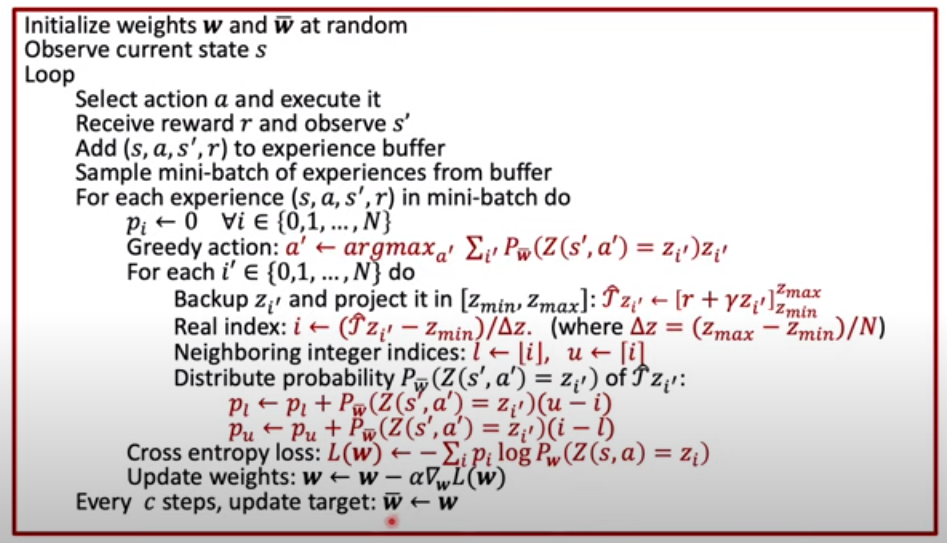

In [ ]:
class DeepQLearning(LightningModule):

  def __init__(self, env_name, policy=greedy, capacity=100_000, 
               batch_size=256, lr=1e-3, hidden_size=128, gamma=0.99, 
               loss_fn=F.smooth_l1_loss, optim=AdamW, samples_per_epoch=10_000, 
               sync_rate=10, a_start=0.5, a_end=0.0, a_last_episode=100,
               b_start=0.4, b_end=1.0, b_last_episode=100, sigma=0.5, 
               n_steps=3, v_min=10.0, v_max=10.0, atoms=51):
    
    super().__init__()

    # Evenly distributed. shape:(N)
    self.support = torch.linspace(v_min, v_max, atoms, device=device)
    self.delta = (v_max - v_min) / (atoms - 1)

    self.env = create_environment(env_name)

    obs_size = self.env.observation_space.shape
    n_actions = self.env.action_space.n

    self.q_net = DQN(hidden_size, obs_size, n_actions, sigma, atoms)

    # A copy that will be used to compute stable targets
    # Will update the values in this copy every sync_rate epochs
    self.target_q_net = copy.deepcopy(self.q_net) 

    self.policy = policy
    self.buffer = ReplayBuffer(capacity=capacity)

    self.save_hyperparameters()

    while len(self.buffer) < self.hparams.samples_per_epoch:
      print(f"{len(self.buffer)} samples in experience buffer. Filling...")
      self.play_episode()

  @torch.no_grad() # We have a policy
  # If we dont include this, action will participate in the learning process
  def play_episode(self, policy=None):
    state = self.env.reset()
    done = False
    transitions = []

    while not done:
      if policy:
        action = policy(state, self.q_net, self.support)
      else:
        action = self.env.action_space.sample()
      next_state, reward, done, info = self.env.step(action)
      exp = (state, action, reward, done, next_state)
      self.buffer.append(exp)
      state = next_state

    for i, (s, a, r, d, ns) in enumerate(transitions):
      batch = transitions[i:i + self.hparams.n_steps]
      # r + gamma * r2 + gamma^2 + r3 + ...
      ret = sum([t[2] * self.hparams.gamma**j for j, t in enumerate(batch)])
      # l stands for last
      _, _, _, ld, ls = batch[-1]
      self.buffer.append((s, a, ret, ld, ls))

  def forward(self, x):
    return self.q_net(x)

  def configure_optimizers(self):
    q_net_optimizer = self.hparams.optim(self.q_net.parameters(), 
                                         lr=self.hparams.lr)
    return [q_net_optimizer] # We might have multiple neural networks, hence
                             # multiple optimizers

  def train_dataloader(self):
    dataset = RLDataset(self.buffer, self.hparams.samples_per_epoch)
    dataloader = DataLoader(
        dataset=dataset,
        batch_size=self.hparams.batch_size
    )
    return dataloader

  def training_step(self, batch, batch_idx):
    indices, weights, states, actions, returns, dones, next_states = batch
    returns = returns.unsqueeze(1)
    dones = dones.unsqueeze(1)
    batch_size = len(indices)

    q_value_probs = self.q_net(states) # (B, A, N)
    action_value_probs = q_value_probs[range(batch_size), actions, :] # (B, N)
    # if values are close to 0, log will be close to -inf => errors
    log_action_value_probs = torch.log(action_value_probs + 1e-6) # (B, N)

    # Gather on the first dimension, the values of the actions taken
    state_action_values = self.q_net(states).gather(1, actions)

    with torch.no_grad():
      next_q_value_probs = self.q_net(next_states) # (B, A, N)
      next_q_values = (next_q_value_probs * self.support) #(B, A)
      next_actions = next_q_values.argmax(dim=-1) # (B,)
      
      next_q_value_probs = self.target_q_net(next_states) # (B, A, N)
      next_action_value_probs = next_q_value_probs[range(batch_size), 
                                                   next_actions, :] # (B, N)

    # [-10, -9, ... 9, 10] r + gamma * S
    m = torch.zeros(batch_size * self.hparams.atoms, device=device,
                    dtype=torch.float64) # (B * N)
    
    Tz = returns + ~dones * self.hparams.gamma ** self.hparams.n_steps * self.support.unsqueeze(0) # (B, 1) * (1, N) = (B, N)
    Tz.clamp_(min=self.hparams.v_min, max=self.hparams.v_max) # (B, N)

    # [-10, ... , 10]

    b = (Tz - self.hparams.v_min) / self.delta
    l, u = b.floor().long(), b.ceil().long()

    offset = torch.arrange(batch_size, device=device).view(-1, 1) * self.hparams.atoms # (B, 1)

    l_idx = (l+offset).flatten() # (B, N)
    u_idx = (u+offset).flatten() # (B, N)

    upper_probs = (next_action_value_probs * (u-b)).flatten() # (B * N)
    lower_probs = (next_action_value_probs * (b-l)).flatten() # (B * N)

    m.index_add_(dim=0, index=l_idx, source=upper_probs)
    m.index_add_(dim=0, index=u_idx, source=lower_probs)

    m = m.reshape() # (B, N)

    # (B, N) -> (B,)
    cross_entropies = - (m * log_action_value_probs).sum(dim=-1)
    
    loss = (weights * cross_entropies).mean()

    for idx, e in zip(indices, cross_entropies):
      self.buffer.update(idx, e.detatch().item())
      
    self.log('episode/Q-error', loss)
    return loss

  def training_epoch_end(self, outputs):
    # Decreasing as we go forward    
    alpha = max(
        self.hparams.a_end,
        self.hparams.a_start - self.current_epoch / self.hparams.a_last_episode
    )
    beta = max(
        self.hparams.b_end,
        self.hparams.b_start - self.current_epoch / self.hparams.b_last_episode
    )
    self.buffer.alpha = alpha
    self.buffer.beta = beta

    self.play_episode(policy=self.policy)
    # RecordStatistics keeps data in return_queue
    self.log('episode/Return', self.env.return_queue[-1])

    # The targets would be more stable after this
    if self.current_epoch % self.hparams.sync_rate == 0:
      self.target_q_net.load_state_dict(self.q_net.state_dict())

In [ ]:
algo = DeepQLearning(
    'PongNoFrameskip-v4',
    lr=1e-4,
    hidden_size=512,
    sigma=0.5,
    samples_per_epoch=10_000,
    a_last_episode=4_000,
    b_last_episode=4_000,
    n_steps=8)

trainer = Trainer(
    gpus=num_gpus,
    max_epochs=5_000,
    log_every_n_steps=1
)

trainer.fit(algo)

In [ ]:
display_video(episode=2000)